In [1]:
import torch
torch.set_default_dtype(torch.float64)

In [2]:
from build_model_and_dataset import *

PACKAGE TINY_AF_AddNG !!!!!!!!!
After layer 1 : x.shape=torch.Size([1, 1])
After layer 2 : x.shape=torch.Size([1, 1])
After layer 3 : x.shape=torch.Size([1, 10])
Time to build the model: 0.04 seconds


In [3]:
MLP_model.skeleton, MLP_model.count_parameters()

({0: {'size': 50}, 1: {'size': 1}, 2: {'size': 1}, 3: {'size': 10}}, 73)

In [4]:
def forward_ajout_NG(self, x, lmbda=torch.tensor(1., device=my_device_0), depth=1):
        """
        Computes the output of the network with the NewNeurons at depth,
        and the norm of the functional update induces by this add.
        """
        #expand = self.alpha.shape[0]
        #self.dico_w['weight'] = torch.concatenate([self.dico_w['weight'], torch.zeros((self.valeurs_propres.shape[0], self.dico_w['weight'].shape[1]), device = my_device)], dim = 1)
        #self.dico_w['bias'] = torch.concatenate([self.dico_w['bias'], torch.zeros(self.dico_w['weight'].shape[1], device = my_device)])
        
        
        self.hAddhookr = self.layer[depth][self.layer_name[depth][0]].register_forward_hook(self.AddHookleft)
        self.hAddhookl = self.layer[depth + 1][self.layer_name[depth + 1][0]].register_forward_hook(self.AddHookright)
        self.copy_fct = copy.deepcopy(self.fct[depth])
        self.hAddHookfct = self.fct[depth].register_forward_hook(self.AddHookfct)
        self.NGhook = self.layer[depth+1][self.layer_name[depth+1][0]].register_forward_hook(self.BestUpdateHook)
        self.ampl_fact_temp = lmbda
        
        if 'B' in self.layer_name[depth]:
            self.hAddHookBN = self.layer[depth]['B'].register_forward_hook(self.AddHookBN)

        self.ampl_fact_temp = lmbda.item()
        with torch.no_grad():
            y_add_NG = self(x)

        self.hAddhookr.remove()
        self.hAddhookl.remove()
        self.hAddHookfct.remove()
        norm = self.norm_x_over_norm_DE
        self.NGhook.remove()
        
        if 'B' in self.layer_name[depth]:
            self.hAddHookBN.remove()

        return y_add_NG, self.norm_x_over_norm_DE_left, self.norm_x_over_norm_DE_right

In [41]:
def BestUpdateHook(module, i, o):
    def onelayerforward(x, w, b, padding=None, stride=None):
        if MLP_model.layer_name[MLP_model.where][0] == 'C':
            return MLP_model.f_conv(x, w, b, padding=padding, stride=stride)
        else:
            return MLP_model.f_lin(x, w, b)

    lmbda = MLP_model.ampl_fact_temp
    padding = getattr(module, 'padding', None)
    stride = getattr(module, 'stride', None)
    w = MLP_model.dico_w['weight']
    b = MLP_model.dico_w['bias']

    DE = onelayerforward(i[0], w, b, padding=padding, stride=stride)
    MLP_model.norm_x_over_norm_DE = torch.linalg.norm(o) / (torch.linalg.norm(DE) + 1e-8)
    print('i[0].norm :', i[0].norm(), i[0].shape)
    print('dico_w.norm :', w.norm(), b.norm())
    print('DE_NG, lmbda :', torch.norm(DE), lmbda)
    return o + lmbda * DE

In [42]:
MLP_model.BestUpdateHook = BestUpdateHook

In [43]:
MLP_model.fct

{1: SELU(), 2: SELU(), 3: Identity()}

In [44]:
def forward_ajout_NG_byhand(model,  X, lmbda=torch.tensor(4., device=my_device_0), depth=1 ) :
    X = torch.flatten(X, start_dim = 1)
    if depth == 1 :
        alphaXOmega = torch.sqrt(lmbda) * model.f_lin(model.fct[1](torch.sqrt(lmbda) * model.f_lin(X, model.alpha, model.bias_alpha)), model.omega, torch.zeros(model.skeleton[2]['size'], device = my_device))
        X = model.fct[1](model.layer[1]['L'](X))
        print('i[0].norm :', X.norm(), X.shape)
        print('dico_w.norm :', model.dico_w['weight'].norm(), model.dico_w['bias'].norm())
        print('DE_NG, lambda :', torch.norm(model.f_lin(X, model.dico_w['weight'], model.dico_w['bias'])), lmbda)
        X = model.fct[2](model.layer[2]['L'](X) + lmbda * model.f_lin(X, model.dico_w['weight'], model.dico_w['bias']) + alphaXOmega) 
        X = model.fct[3](model.layer[3]['L'](X))
        
    if depth == 2 :
        X = model.fct[1](model.layer[1]['L'](X))
        alphaXOmega = torch.sqrt(lmbda) * model.f_lin(model.fct[1](torch.sqrt(lmbda) *model.f_lin(X, model.alpha, model.bias_alpha)), model.omega, torch.zeros(model.skeleton[2]['size'], device = my_device))
        X = model.fct[2](model.layer[2]['L'](X)) 
        X = model.fct[3](model.layer[3]['L'](X)+ lmbda * model.f_lin(X, model.dico_w['weight'], model.dico_w['bias']) + alphaXOmega)
    return(X)
        

In [45]:
MLP_model.layer_name, MLP_model.fct

({1: 'L', 2: 'L', 3: 'L'}, {1: SELU(), 2: SELU(), 3: Identity()})

In [46]:
X, Y = MLP_model.get_batch(indices = torch.arange(10))

In [47]:
MLP_model.how_to_define_batchsize(MLP_model, 1)

In [48]:
depth = 1

In [49]:
MLP_model.dico_w = None
EB.compute_optimal_update(MLP_model, depth + 1, update = False, compute_gain= False)
EB.add_neurons(MLP_model, depth, update = False, compute_gain= False)



*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


In [50]:
Y = MLP_model(X)

In [51]:
Y_T = forward_ajout_NG_byhand(MLP_model,  X, lmbda=torch.tensor(4., device=my_device_0), depth=depth )

i[0].norm : tensor(1.8224, grad_fn=<LinalgVectorNormBackward0>) torch.Size([10, 1])
dico_w.norm : tensor(0.0512) tensor(0.0841)
DE_NG, lambda : tensor(0.3052, grad_fn=<LinalgVectorNormBackward0>) tensor(4.)


In [52]:
Y_t = forward_ajout_NG(MLP_model, X, lmbda=torch.tensor(4., device=my_device_0), depth=depth)

i[0].norm : tensor(1.8224) torch.Size([10, 1])
dico_w.norm : tensor(0.0512) tensor(0.0841)
DE_NG, lmbda : tensor(0.3052) 4.0


In [ ]:
3.163 / 0.2446 

In [56]:
Y - Y_t[0]

tensor([[-0.1745,  1.3913,  2.2874,  2.1857,  2.0244, -1.9963, -1.2768, -2.2090,
         -0.2394,  1.5026],
        [-0.1847,  1.4724,  2.4207,  2.3131,  2.1424, -2.1127, -1.3512, -2.3377,
         -0.2534,  1.5901],
        [-0.2776,  2.2137,  3.6394,  3.4777,  3.2210, -3.1763, -2.0315, -3.5146,
         -0.3810,  2.3907],
        [-0.3218,  2.5658,  4.2183,  4.0308,  3.7333, -3.6815, -2.3546, -4.0737,
         -0.4416,  2.7710],
        [-0.3263,  2.6021,  4.2780,  4.0879,  3.7862, -3.7337, -2.3880, -4.1313,
         -0.4478,  2.8102],
        [-0.2934,  2.3394,  3.8462,  3.6753,  3.4040, -3.3568, -2.1469, -3.7143,
         -0.4026,  2.5266],
        [-0.2141,  1.7071,  2.8067,  2.6819,  2.4840, -2.4495, -1.5667, -2.7104,
         -0.2938,  1.8437],
        [-0.2782,  2.2181,  3.6466,  3.4846,  3.2274, -3.1826, -2.0355, -3.5216,
         -0.3817,  2.3955],
        [-0.2137,  1.7037,  2.8011,  2.6766,  2.4790, -2.4447, -1.5635, -2.7050,
         -0.2932,  1.8400],
        [-0.2374,  

In [57]:
Y - Y_t[0] - (Y - Y_T)

tensor([[-0.1761,  1.4039,  2.3081,  2.2056,  2.0428, -2.0144, -1.2884, -2.2290,
         -0.2416,  1.5162],
        [-0.1689,  1.3467,  2.2141,  2.1157,  1.9595, -1.9323, -1.2359, -2.1381,
         -0.2318,  1.4544],
        [-0.1689,  1.3467,  2.2141,  2.1157,  1.9595, -1.9323, -1.2359, -2.1381,
         -0.2318,  1.4544],
        [-0.1689,  1.3467,  2.2141,  2.1157,  1.9595, -1.9323, -1.2359, -2.1381,
         -0.2318,  1.4544],
        [-0.1689,  1.3467,  2.2141,  2.1157,  1.9595, -1.9323, -1.2359, -2.1381,
         -0.2318,  1.4544],
        [-0.1689,  1.3467,  2.2141,  2.1157,  1.9595, -1.9323, -1.2359, -2.1381,
         -0.2318,  1.4544],
        [-0.1787,  1.4249,  2.3426,  2.2385,  2.0733, -2.0445, -1.3076, -2.2623,
         -0.2452,  1.5389],
        [-0.1689,  1.3467,  2.2141,  2.1157,  1.9595, -1.9323, -1.2359, -2.1381,
         -0.2318,  1.4544],
        [-0.1788,  1.4257,  2.3440,  2.2398,  2.0745, -2.0457, -1.3084, -2.2636,
         -0.2454,  1.5398],
        [-0.1689,  

In [58]:
Y_T / Y_t[0]

tensor([[ 8.3797e-01, -4.7360e-01, -3.5005e-01, -2.9745e+00, -3.4747e-01,
         -1.5166e+00,  2.3016e+01, -5.8792e-01,  5.5948e-01, -1.2643e+00],
        [ 8.5256e-01,  5.2925e-02,  1.0764e-01, -6.3738e-01,  1.0882e-01,
         -3.1117e-01, -2.3213e+00,  4.9296e-03,  6.3167e-01, -2.3634e-01],
        [ 8.5673e-01,  2.0219e-01,  2.4138e-01, -2.3719e-01,  2.4223e-01,
         -4.1416e-02, -1.0054e+00,  1.6840e-01,  6.5665e-01,  6.3485e-03],
        [ 8.6423e-01,  3.8977e-01,  4.1296e-01,  1.6218e-01,  4.1347e-01,
          2.5679e-01, -1.3132e-01,  3.7019e-01,  6.9677e-01,  2.8144e-01],
        [ 8.6455e-01,  3.9617e-01,  4.1889e-01,  1.7420e-01,  4.1939e-01,
          2.6627e-01, -1.0950e-01,  3.7701e-01,  6.9836e-01,  2.9031e-01],
        [ 8.5987e-01,  2.9055e-01,  3.2171e-01, -3.6924e-02,  3.2239e-01,
          1.0421e-01, -5.2730e-01,  2.6396e-01,  6.7412e-01,  1.3978e-01],
        [ 8.3907e-01, -2.4742e-01, -1.5895e-01, -1.6251e+00, -1.5708e-01,
         -9.0641e-01, -1.0326e+0

In [30]:
MLP_model.dico_w

{'weight': tensor([[-0.0571],
         [-0.0504],
         [ 0.0147],
         [ 0.0640],
         [ 0.0237],
         [-0.0191],
         [-0.0065],
         [-0.0025],
         [ 0.0238],
         [ 0.0095]]),
 'bias': tensor([-0.0657, -0.0163,  0.0198, -0.1586,  0.0009,  0.0434,  0.0640,  0.0477,
          0.0600,  0.0048])}

In [10]:
MLP_model.alpha.shape

torch.Size([1, 50])

In [3]:
expe = str(5)
name_file_expe = 'results/StrategyOnAmplitudeFactor/' + expe + '/'

In [4]:
os.mkdir(name_file_expe)

In [5]:
MLP_model.how_to_define_batchsize

<function build_model_and_dataset.define_Batchsize(model, depth, method=None)>

In [6]:
to_add = [1, 2] # depths where we want to add neurons
nbr_steps_betw_adding = 0 # number of gradient step between each architecture growth

In [7]:
df_tracker = pd.DataFrame()
A_tr, A_te, L_tr, L_te, T = np.array([]), np.array([]), np.array([]), np.array([]), np.array([0])

In [8]:
def update_quantity_of_interest(method = 'Add', depth = 1) :
    global L_tr, L_te, A_tr, A_te, T, df_tracker
    X, Y = MLP_model.get_batch(indices=torch.arange(MLP_model.len_train_dataset))
    dico_DV = {'DV_norm_' + str(d) : np.sqrt((MLP_model.deplacement_voulu(d, X=X, Y = Y).norm()**2 / X.shape[0]).item()) for d in [1, 2, 3]}
    
    if method == 'Add' :
        #DV = MLP_model.deplacement_voulu(depth, X=X, Y = Y)
        dico_tracker = {'vps' + str(i) : [ MLP_model.valeurs_propres[i].item()] for i in range(len(MLP_model.valeurs_propres))}
        dico_tracker.update({'depth_add' : depth, 'nbr_added_neuron': MLP_model.nbr_added_neuron,
                        'sum_vps_sq' : (MLP_model.valeurs_propres ** 2).sum().item(),
                        'count': count, 'DV_proj_norm_sq': MLP_model.DV_proj_norm_sq.item()})

    elif method == 'NG' : 
        #DV = MLP_model.deplacement_voulu(depth + 1, X=X, Y = Y)
        dico_tracker = {}
        dico_tracker.update({'depth_NG' : depth, 'nbr_added_neuron': MLP_model.nbr_added_neuron,
                        'count': count})
    else:
        assert False
        
    dico_tracker.update({
        #'accroissement' : [dico_EB[best_depth]['accroissement']], 'portion_gain' : [dico_EB[best_depth]['portion_gain']],
                        'nbr_parameters_apres' : [MLP_model.count_parameters()], 'nbr_parameters_avant' : [nbr_parameters_avant],
                        'T' : [T[-1]], 'len_L_tr' : [len(L_tr)], 'lu_conv' : [MLP_model.lu_conv],
                        'size_layer_1' : [MLP_model.skeleton[1]['size']], 'size_layer_2' : [MLP_model.skeleton[2]['size']]})
    dico_tracker.update(dico_DV)
    df_tracker = pd.concat([df_tracker, pd.DataFrame.from_dict(dico_tracker)], ignore_index=True)
    
    L_tr = np.concatenate([L_tr, l_tr.unsqueeze(0)])
    L_te = np.concatenate([L_te, l_te.unsqueeze(0)])
    A_tr = np.concatenate([A_tr, a_tr.unsqueeze(0)])
    A_te = np.concatenate([A_te, a_te.unsqueeze(0)])
    #T = np.concatenate([T, t.unsqueeze(0) +  T[-1]])
    T = np.zeros(L_tr.shape[0] +1)
    
    
def AugBatchSizeLearning() :
    MLP_model.batch_size = math.ceil(np.sqrt(MLP_model.count_parameters() / nbr_parameters_avant) *  MLP_model.batch_size)
    #MLP_model.batch_size = math.ceil(MLP_model.count_parameters() / nbr_parameters_avant *  MLP_model.batch_size)

In [9]:
def compute_Loss_full(model):
    """
    Computes the avearged and individual losses of the network for a minibatch 
    either when adding the BestUpdate or the Newneurons, 
    with the amplitude factor 'ampl_fact'.
    """
    indx = torch.arange(model.len_train_dataset)
    L_tr = torch.tensor(0., device = my_device)
    A_tr = torch.tensor(0., device = my_device)
    for sous_indices in range(math.ceil(indx.shape[0]/model.max_batch_estimation)) :
        sous_ind = indx[sous_indices * model.max_batch_estimation : (sous_indices + 1) * model.max_batch_estimation]
        sous_seed = model.seed_lmbda[sous_indices * model.max_batch_estimation : (sous_indices + 1) * model.max_batch_estimation]
        X, Y = model.get_batch(indices = sous_ind, seed = sous_seed[0], device = my_device_0)
        #l[sous_indices * model.max_batch_estimation : (sous_indices + 1) * model.max_batch_estimation] = model.Loss(fct_to_apply(X, depth = depth, lmbda = ampl_fact)[0], Y.to(my_device), reduction = 'none')
        with torch.no_grad() :
            Y_pred = model(X)
        L_tr += model.Loss(Y_pred, Y, reduction = 'sum') /  indx.shape[0]
        A_tr += UTILS.calculate_accuracy(Y_pred, Y) * sous_ind.shape[0] / indx.shape[0]

    indx = torch.arange(model.len_test_dataset)
    L_te = torch.tensor(0., device = my_device)
    A_te = torch.tensor(0., device = my_device)

    for sous_indices in range(math.ceil(indx.shape[0]/model.max_batch_estimation)) :
        sous_ind = indx[sous_indices * model.max_batch_estimation : (sous_indices + 1) * model.max_batch_estimation]
        sous_seed = model.seed_lmbda[sous_indices * model.max_batch_estimation : (sous_indices + 1) * model.max_batch_estimation]
        X, Y = model.get_batch(indices = sous_ind, seed = sous_seed[0], device = my_device_0, data = 'te')
        #l[sous_indices * model.max_batch_estimation : (sous_indices + 1) * model.max_batch_estimation] = model.Loss(fct_to_apply(X, depth = depth, lmbda = ampl_fact)[0], Y.to(my_device), reduction = 'none')
        with torch.no_grad() :
            Y_pred = model(X)
        L_te += model.Loss(Y_pred, Y, reduction = 'sum') /  indx.shape[0]
        A_te += UTILS.calculate_accuracy(Y_pred, Y) * sous_ind.shape[0] / indx.shape[0]
    return(L_tr, L_te, A_tr, A_te) 

In [10]:
count = 1
t_0, t = 0, 0

In [13]:
MLP_model.Force_NoNG = True

In [14]:
for j in tqdm(range(20)) :

    ## search for the best depth to add the new neurons ##
    nbr_parameters_avant = MLP_model.count_parameters()
    gc.collect()
    torch.cuda.empty_cache()
    depth_ajout = to_add
    depth_in_decreasing_criterion, dico_EB = EB.where_is_EB_best_solved(MLP_model, depths = depth_ajout)

    best_depth = depth_in_decreasing_criterion[0]
    dico_EB_bd = dico_EB[best_depth]
    alpha, omega, bias_alpha, vps = dico_EB_bd['alpha'], dico_EB_bd['omega'], dico_EB_bd['bias_alpha'], dico_EB_bd['vps']
    lambda_method = dico_EB_bd['beta_min']

    MLP_model.alpha, MLP_model.omega, MLP_model.bias_alpha, MLP_model.valeurs_propres = None, None, None, torch.tensor([])
    MLP_model.TAB_Add = None


    if lambda_method > 0 :
        MLP_model.dico_w, MLP_model.lambda_method = dico_EB_bd['dico_w'], dico_EB_bd['beta_min']
        EB.add_neurons(MLP_model, best_depth, alpha = alpha, omega = omega, bias_alpha = bias_alpha, valeurs_propres = vps)
        MLP_model.lambda_method = torch.tensor(0., device = my_device_0)
    #########################################################


    l_tr, l_te, a_tr, a_te = compute_Loss_full(MLP_model)
    update_quantity_of_interest(method = 'Add', depth = best_depth)

    for depth in range(1, 4) :
        nbr_parameters_avant = MLP_model.count_parameters()
        gc.collect()
        MLP_model.dico_w = None
        MLP_model.how_to_define_batchsize(MLP_model, depth, method = 'NG')
        EB.compute_optimal_update(MLP_model, depth, update = True)

        l_tr, l_te, a_tr, a_te = compute_Loss_full(MLP_model)
        t = torch.tensor(time.time() - t_0, device = my_device)
        update_quantity_of_interest(method = 'NG', depth = depth)

    count += 1

    df_performance = pd.DataFrame.from_dict({'L_tr' : L_tr, 'L_te' : L_te, 'A_tr' : A_tr, 'A_te' : A_te, 'T' : T[1:], 
                                             'BatchSize' : np.ones(A_te.shape) * MLP_model.batch_size})
    df_tracker.to_csv(name_file_expe + '/df_tracker.csv')
    df_performance.to_csv(name_file_expe + '/df_performance.csv')
    MLP_model.T = T[-1]
    MLP_model.len_L_tr = len(L_tr)
    UTILS.save_model_to_file(MLP_model, path = name_file_expe + '/' , name='model_' + str(count))





  0%|          | 0/20 [00:00<?, ?it/s]



*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.4471781551837921
norm_x_over_norm_DE_depthp1 :  0.3821314871311188
L_plus < L_moins: 0.4070238769054413 < 0.40702396631240845
Delta Loss :  [0.0, 0.0, -5.960464477539063e-08]  ... [-0.009365499019622803, -0.012132525444030762, 0.0008791685104370117]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0009765625, 0.001953125, 0.00390625]
rate of decrease : 0.02262425608932972 ampli_fct : 0.001953125 L[0] : 0.5362618565559387


*** started  Add at  2 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 9.006092071533203
norm_x_over_norm_DE_depthp1 :  202.0530242919922
(alpha, omega) <-- (-alpha, -omega)
Delta 



*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -5.960464477539063e-08, -1.7881393432617188e-07]  ... [-0.003975927829742432, -0.005283653736114502, -0.00014451146125793457]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00048828125, 0.0009765625, 0.001953125]
rate of decrease : 0.013135753571987152 ampli_fct : 0.0009765625 L[0] : 0.4022345244884491
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.018698543310165405, -0.021854549646377563, -0.005798161029815674]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0625, 0.125, 0.25]
rate of decrease : 0.055402304977178574 ampli_fct : 0.125 L[0] : 0.3944700360298157
*** updated layer : 3 ***


*** started  Add at  1 ***
Batch size f



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -1.043081283569336e-07, -2.086162567138672e-07]  ... [-0.005654573440551758, -0.006446897983551025, 0.0029793530702590942]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00048828125, 0.0009765625, 0.001953125]
rate of decrease : 0.027370944619178772 ampli_fct : 0.0009765625 L[0] : 0.23553802073001862
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -8.940696716308594e-08, -2.384185791015625e-07]  ... [-0.00494520366191864, -0.006815418601036072, -0.0024067461490631104]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00048828125, 0.0009765625, 0.001953125]
rate of decrease : 0.029754644259810448 ampli_fct : 0.0009765625 L[0] : 0.22905394434928894
**



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -6.705522537231445e-08, -2.1606683731079102e-07]  ... [-0.003455512225627899, -0.0034756511449813843, 0.005909830331802368]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00048828125, 0.0009765625, 0.001953125]
rate of decrease : 0.035461798310279846 ampli_fct : 0.0009765625 L[0] : 0.09801113605499268
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -8.195638656616211e-08, -1.564621925354004e-07]  ... [-0.0033980458974838257, -0.004083968698978424, 0.0021617934107780457]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00048828125, 0.0009765625, 0.001953125]
rate of decrease : 0.043237488716840744 ampli_fct : 0.0009765625 L[0] : 0.09445434808731079




*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -1.862645149230957e-08, -4.0978193283081055e-08]  ... [-0.000948004424571991, -0.0014003664255142212, -0.0008924715220928192]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.000244140625, 0.00048828125, 0.0009765625]
rate of decrease : 0.03948858752846718 ampli_fct : 0.00048828125 L[0] : 0.03546256199479103
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -2.60770320892334e-08, -4.470348358154297e-08]  ... [-0.0007163397967815399, -0.001106753945350647, -0.0009320266544818878]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.000244140625, 0.00048828125, 0.0009765625]
rate of decrease : 0.03246103227138519 ampli_fct : 0.00048828125 L[0] : 0.0340948477



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -1.0244548320770264e-08, -2.421438694000244e-08]  ... [-0.00040395185351371765, -0.000569797120988369, -0.0003020046278834343]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.000244140625, 0.00048828125, 0.0009765625]
rate of decrease : 0.05109748616814613 ampli_fct : 0.00048828125 L[0] : 0.011151176877319813
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -1.0244548320770264e-08, -2.421438694000244e-08]  ... [-0.0003140028566122055, -0.0004598526284098625, -0.0002618422731757164]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.000244140625, 0.00048828125, 0.0009765625]
rate of decrease : 0.043415043503046036 ampli_fct : 0.00048828125 L[0] : 0.0105



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -9.313225746154785e-09, -9.313225746154785e-09]  ... [-0.00018133968114852905, -0.00027567893266677856, -0.00023745745420455933]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.000244140625, 0.00048828125, 0.0009765625]
rate of decrease : 0.052037887275218964 ampli_fct : 0.00048828125 L[0] : 0.005297658033668995
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -7.916241884231567e-09, -1.1175870895385742e-08]  ... [-0.0001474553719162941, -0.0001995260827243328, -1.1401250958442688e-05]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.000244140625, 0.00048828125, 0.0009765625]
rate of decrease : 0.0397697389125824 ampli_fct : 0.00048828125 L[0] : 0.00

In [13]:
#MLP_model.valeurs_propres

In [14]:
alpha, omega, bias_alpha, vps = dico_EB_bd['alpha'], dico_EB_bd['omega'], dico_EB_bd['bias_alpha'], dico_EB_bd['vps']
lambda_method = dico_EB_bd['beta_min']

In [15]:
MLP_model.alpha_computed

tensor([[-2.3007e-02, -1.1111e-02, -3.7670e-03,  1.0008e-03,  2.3269e-02,
          1.3756e-02,  5.9638e-03,  1.5798e-02,  6.9218e-03, -5.2209e-05],
        [ 1.4915e-02,  7.1425e-03,  2.2854e-02, -9.5602e-03,  1.7042e-02,
          9.6282e-03, -4.4316e-02,  3.0939e-02, -2.7397e-02, -5.8801e-05],
        [-1.1243e-01,  1.1688e-03, -7.7932e-02,  2.8513e-02,  3.0176e-02,
         -2.2496e-03,  1.0548e-02,  3.7087e-02,  2.0620e-02,  1.4862e-04],
        [ 1.7890e-02, -9.2132e-03,  4.5942e-02, -4.5711e-02, -3.2457e-02,
         -5.4192e-03, -5.0579e-02,  5.7770e-03, -1.5855e-02,  9.0855e-05],
        [-1.3695e-01, -3.1827e-02, -1.4264e-01,  9.4260e-02, -1.7859e-03,
         -7.5799e-02,  5.4262e-02,  7.1206e-02, -6.3926e-03,  4.0365e-06],
        [ 8.7530e-01, -9.8631e-01, -5.9046e-01,  2.8203e+00,  1.0415e+00,
         -1.4640e+00, -5.9322e-01,  1.8198e+00, -1.4635e+00,  1.5028e-02],
        [ 6.4485e-02, -8.7803e-01, -4.5183e-01,  1.5656e+00, -4.8077e-01,
         -7.3165e-01,  6.1813e-0

In [16]:
MLP_model.skeleton

{0: {'size': 50}, 1: {'size': 41}, 2: {'size': 54}, 3: {'size': 10}}

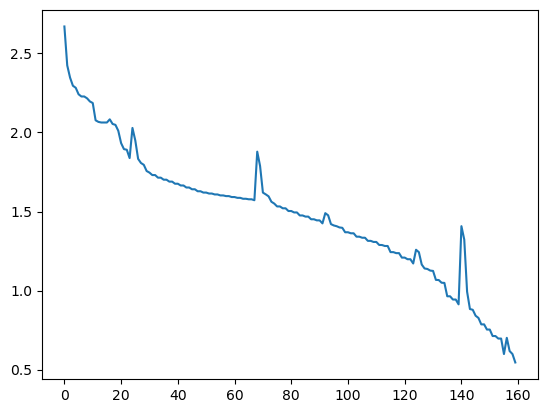

In [17]:
plt.plot(df_performance['L_tr'])

In [18]:
Y_true = torch.concatenate([torch.sin(TINY.X_train_rescale[:, 0, 0, :].sum(dim = -1, keepdim = True)*k) for k in range(1, 11)], dim = 1)

In [16]:
Y_true.shape

torch.Size([500, 10])

In [17]:
Y = torch.nn.functional.one_hot(Y_true.argmax(1)).float()

In [18]:
Y.shape

torch.Size([500, 10])

In [19]:
for i in range(10) :
    print(Y[:, i].mean())

tensor(0.1260)
tensor(0.0960)
tensor(0.1200)
tensor(0.1000)
tensor(0.0540)
tensor(0.1080)
tensor(0.0680)
tensor(0.0960)
tensor(0.0980)
tensor(0.1340)


In [20]:
MLP_model.skeleton

{0: {'size': 50}, 1: {'size': 17}, 2: {'size': 15}, 3: {'size': 10}}